In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import cv2
%matplotlib inline

In [54]:
ls model

 Volume in drive E is New Volume
 Volume Serial Number is 4457-A0E3

 Directory of E:\Image Processing\model-1\model

02-06-2021  23:15    <DIR>          .
02-06-2021  23:15    <DIR>          ..
22-03-2020  10:12           930,127 haarcascade_frontalface_default.xml
02-06-2021  21:45         4,082,044 p_50.pickle
02-06-2021  23:15            80,157 preprocessing_mean.pickle
02-06-2021  23:13         1,035,376 svm_best_model.pickle
               4 File(s)      6,127,704 bytes
               2 Dir(s)  307,736,723,456 bytes free


In [55]:
#Load all models
haar=cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
#pickel files
pca_model=pickle.load(open('./model/p_50.pickle','rb'))
mean=pickle.load(open('./model/preprocessing_mean.pickle','rb'))
svm_model=pickle.load(open('./model/svm_best_model.pickle','rb'))
print("Success")

Success


In [56]:
ls data

 Volume in drive E is New Volume
 Volume Serial Number is 4457-A0E3

 Directory of E:\Image Processing\model-1\data

03-06-2021  00:29    <DIR>          .
03-06-2021  00:29    <DIR>          ..
02-06-2021  15:59    <DIR>          cropped_images
02-06-2021  15:06    <DIR>          female
02-06-2021  15:06    <DIR>          male
14-01-2020  22:16            25,144 male_000281.jpg
02-06-2021  23:34        29,196,064 mi5.mp4
02-06-2021  21:40       437,462,378 normalized_data.npz
02-06-2021  21:50         2,289,820 pca_50_y_mean.pickle.npz
02-06-2021  18:20        54,866,950 resized_images.pickle
02-06-2021  23:36            63,486 selena-gomez.jpg
               6 File(s)    523,903,842 bytes
               5 Dir(s)  307,736,723,456 bytes free


In [57]:
font=cv2.FONT_HERSHEY_SIMPLEX
predict_gender=['Male','Female']

In [58]:
#Pipeline model
def pipeline(img,color='rgb'):
            #convert to grayscale
            if color=='rgb':
                gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            else:
                gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            #CROP FACE USING HAAR CASCADE CLASSIFIER
            face=haar.detectMultiScale(gray,1.5,3)
            for x,y,w,h in face:
                cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
                cropping=gray[y:y+h,x:x+w]
                #normalization
                cropping=cropping/255.0
                #resize image (100,100)
                if cropping.shape[1]>=100:
                    cropping_resize=cv2.resize(cropping,(100,100),cv2.INTER_AREA)
                else:
                    cropping_resize=cv2.resize(cropping,(100,100),cv2.INTER_CUBIC)
                #flattening (1x10000)
                cropping_reshape=cropping_resize.reshape(1,10000)
                #subtract with mean
                cropping_mean=cropping_reshape-mean
                #get eigen image from pca model
                eigen_img=pca_model.transform(cropping_mean)
                #pass img to svm model
                result=svm_model.predict_proba(eigen_img)[0]
                predict=result.argmax() #0 or 1
                score=result[predict]
                text="%s : %0.2f"%(predict_gender[predict],score)
                cv2.putText(img,text,(x,y),font,1,(0,255,0),2)
            return img



In [59]:
from PIL import Image

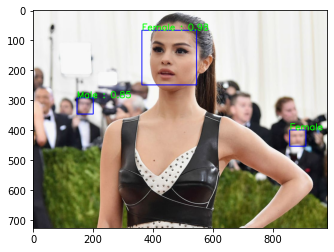

In [60]:
path='./data/selena-gomez.jpg'
color='bgr'
img=Image.open(path)
img=np.array(img)
img=pipeline(img)
plt.imshow(img)

# Pipeline applied to video

In [64]:
cap=cv2.VideoCapture('./data/mi5.mp4')
while True:
    ret,frame=cap.read()
    if ret==False:
        break
    frame=pipeline(frame)
    cv2.imshow("frame",frame)
    if cv2.waitKey(100)==ord('q'):
        break
cv2.destroyAllWindows()
cap.release()